In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import io
import torch 
import time
import numpy as np
from collections import OrderedDict

%pylab inline
rcParams["figure.figsize"] = (16,5)
sys.path.append('/home/erogol/projects/')

import librosa
import librosa.display

from TTS.models.tacotron import Tacotron 
from TTS.layers import *
from TTS.utils.data import *
from TTS.utils.audio import AudioProcessor
from TTS.utils.generic_utils import load_config
from TTS.utils.text import text_to_sequence

import IPython
from IPython.display import Audio
from utils import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def tts(model, text, CONFIG, use_cuda, ap, figures=True):
    t_1 = time.time()
    waveform, alignment, spectrogram = create_speech(model, text, CONFIG, use_cuda, ap) 
    print(" >  Run-time: {}".format(time.time() - t_1))
    if figures:                                                                                                         
        visualize(alignment, spectrogram, CONFIG)                                                                       
    IPython.display.display(Audio(waveform, rate=CONFIG.sample_rate))  
    return alignment, spectrogram

In [3]:
# Set constants
ROOT_PATH = '/home/erogol/projects/models/LJSpeech/April-13-2018_07:06PM-e00bc66/'
MODEL_PATH = ROOT_PATH + '/checkpoint_172960.pth.tar'
CONFIG_PATH = ROOT_PATH + '/config.json'
OUT_FOLDER = ROOT_PATH + '/test/'
CONFIG = load_config(CONFIG_PATH)
use_cuda = False

In [4]:
# load the model
model = Tacotron(CONFIG.embedding_size, CONFIG.num_freq, CONFIG.num_mels, CONFIG.r)

# load the audio processor
ap = AudioProcessor(CONFIG.sample_rate, CONFIG.num_mels, CONFIG.min_level_db,
                    CONFIG.frame_shift_ms, CONFIG.frame_length_ms, CONFIG.preemphasis,
                    CONFIG.ref_level_db, CONFIG.num_freq, CONFIG.power, griffin_lim_iters=80)         


# load model state
if use_cuda:
    cp = torch.load(MODEL_PATH)
else:
    cp = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)

# load the model
model.load_state_dict(cp['model'])
if use_cuda:
    model.cuda()
model.eval()

 | > Number of characted : 149


Tacotron(
  (embedding): Embedding(149, 256)
  (encoder): Encoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): Linear(in_features=256, out_features=256)
        (1): Linear(in_features=256, out_features=128)
      )
      (relu): ReLU()
      (dropout): Dropout(p=0.5)
    )
    (cbhg): CBHG(
      (relu): ReLU()
      (conv1d_banks): ModuleList(
        (0): BatchNormConv1d(
          (conv1d): Conv1d (128, 128, kernel_size=(1,), stride=(1,), bias=False)
          (bn): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True)
          (activation): ReLU()
        )
        (1): BatchNormConv1d(
          (conv1d): Conv1d (128, 128, kernel_size=(2,), stride=(1,), padding=(1,), bias=False)
          (bn): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True)
          (activation): ReLU()
        )
        (2): BatchNormConv1d(
          (conv1d): Conv1d (128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn): BatchNorm1d(128, eps=0.001, mo

### EXAMPLES FROM TRAINING SET

In [5]:
import pandas as pd
df = pd.read_csv('/data/shared/KeithIto/LJSpeech-1.0/metadata_val.csv', delimiter='|')

Latona's findings were also confirmed by Ronald G. Wittmus, another FBI fingerprint expert.
 >  Run-time: 11.577292203903198


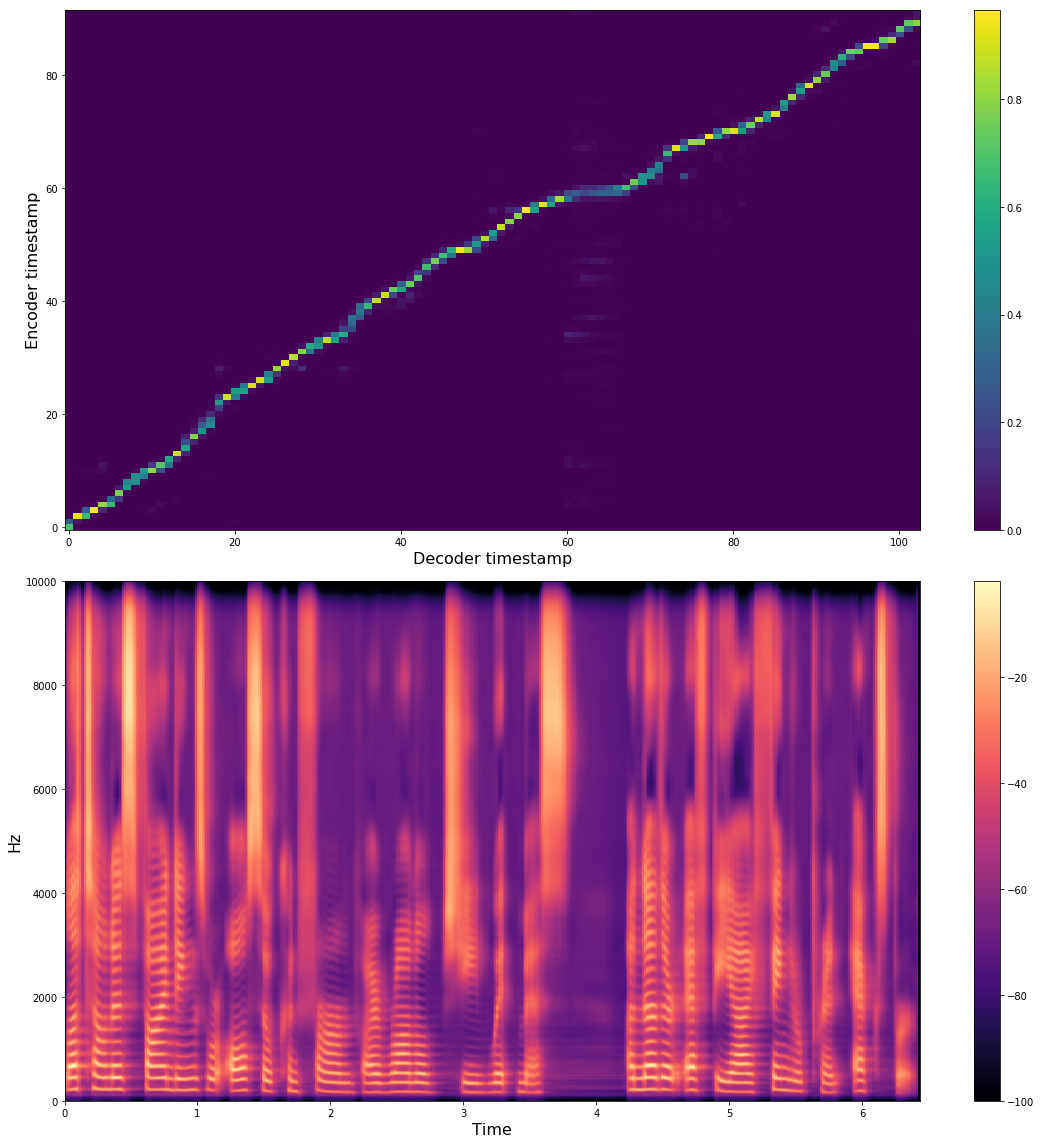

In [6]:
sentence = df.iloc[2, 1]
print(sentence)
model.decoder.max_decoder_steps = 250
align, spec = tts(model, sentence, CONFIG, use_cuda, ap)

### Comparision with https://mycroft.ai/blog/available-voices/

 >  Run-time: 11.755356550216675


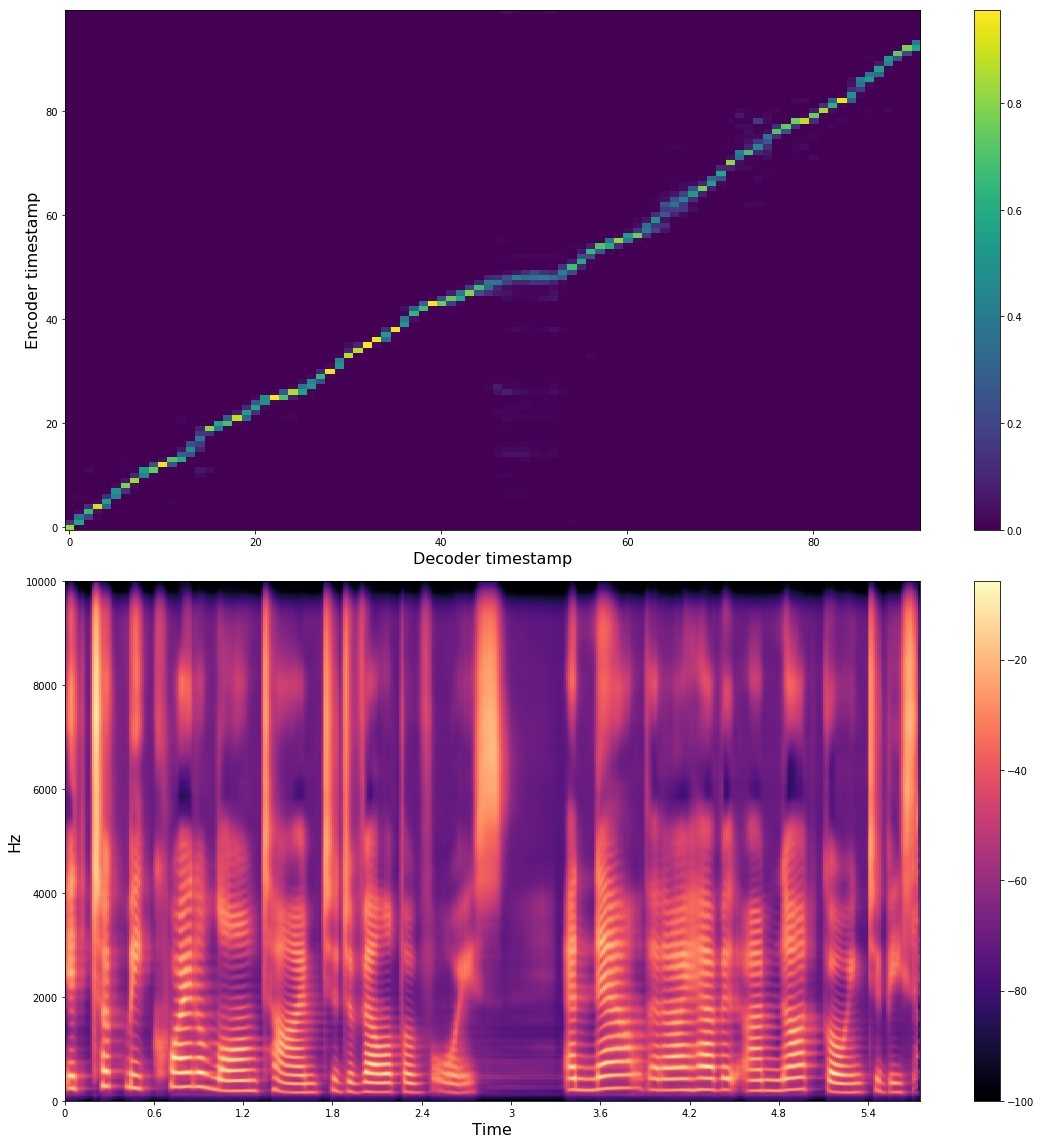

In [7]:
sentence =  "It took me quite a long time to develop a voice, and now that I have it I'm not going to be silent."
model.decoder.max_decoder_steps = 250
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

 >  Run-time: 4.867138147354126


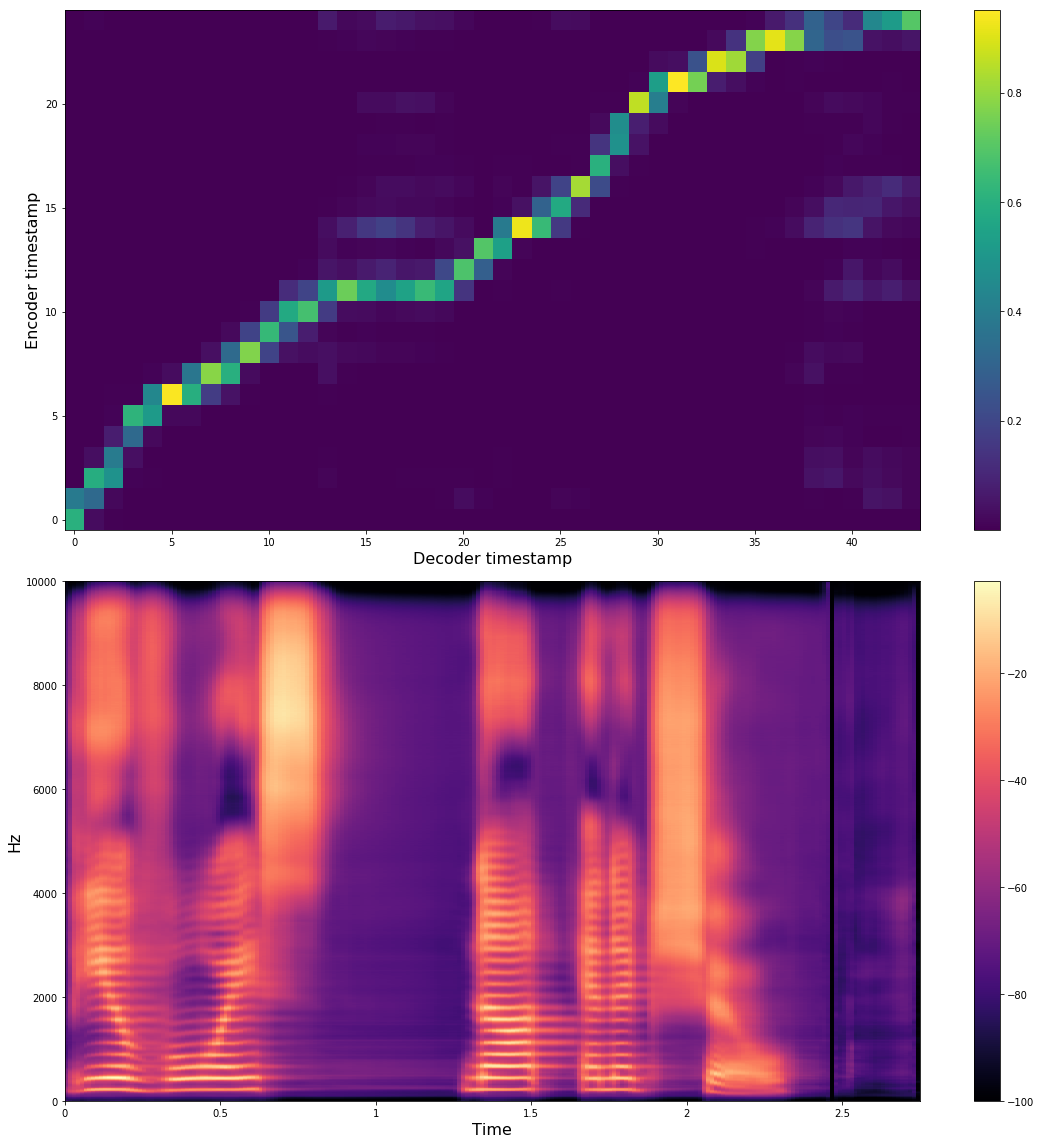

In [8]:
sentence = "Be a voice, not an echo."  # 'echo' is not in training set. 
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

 !! Decoder stopped with 'max_decoder_steps'.                           Something is probably wrong.
 >  Run-time: 29.618252754211426


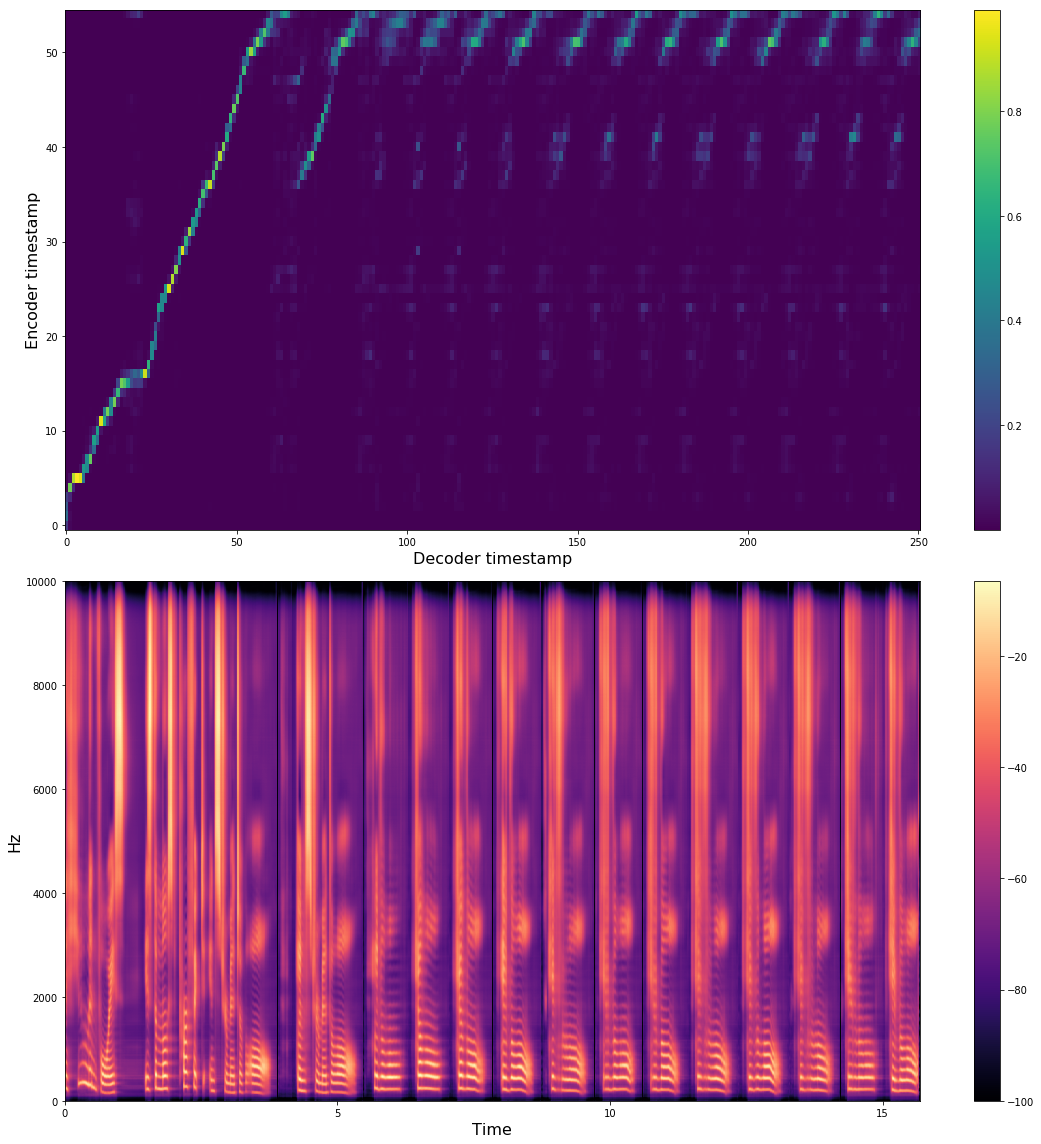

In [9]:
sentence = "The human voice is the most perfect instrument of all."
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

 >  Run-time: 9.181858539581299


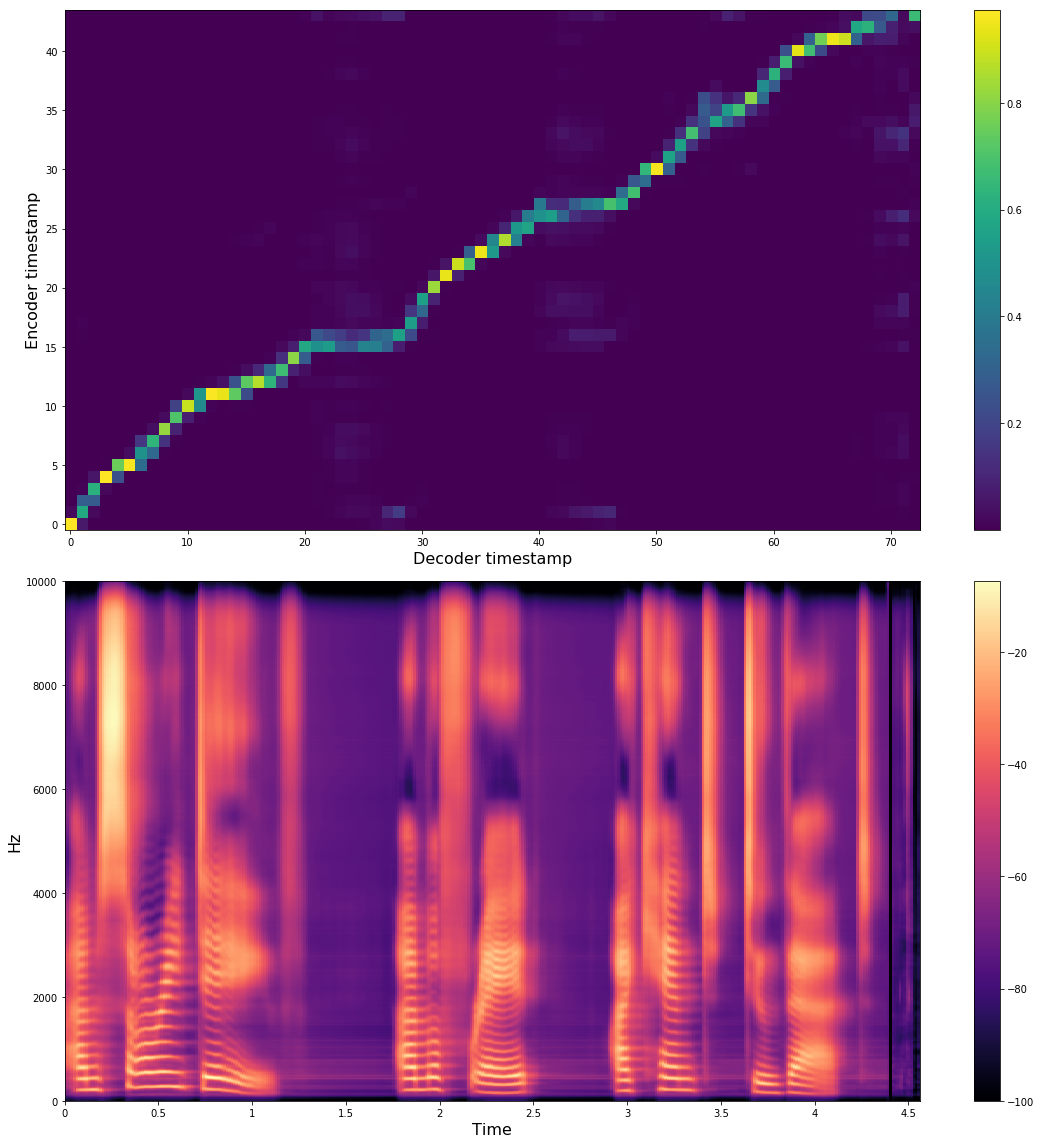

In [10]:
sentence = "I'm sorry Dave. I'm afraid I can't do that."
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

 >  Run-time: 10.925827741622925


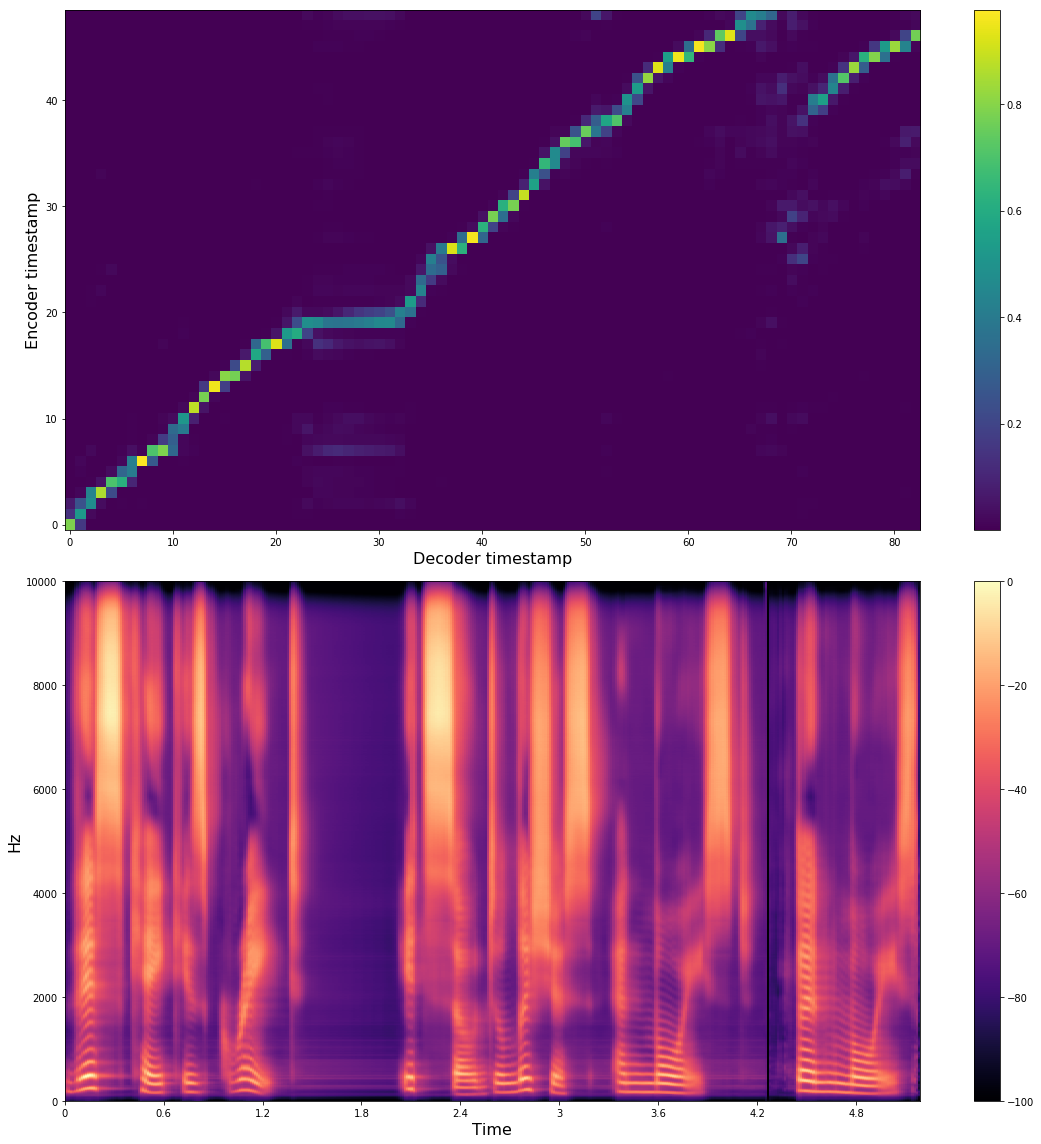

In [11]:
sentence = "This cake is great. It's so delicious and moist."
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

### Comparison with https://keithito.github.io/audio-samples/

 >  Run-time: 8.598266839981079


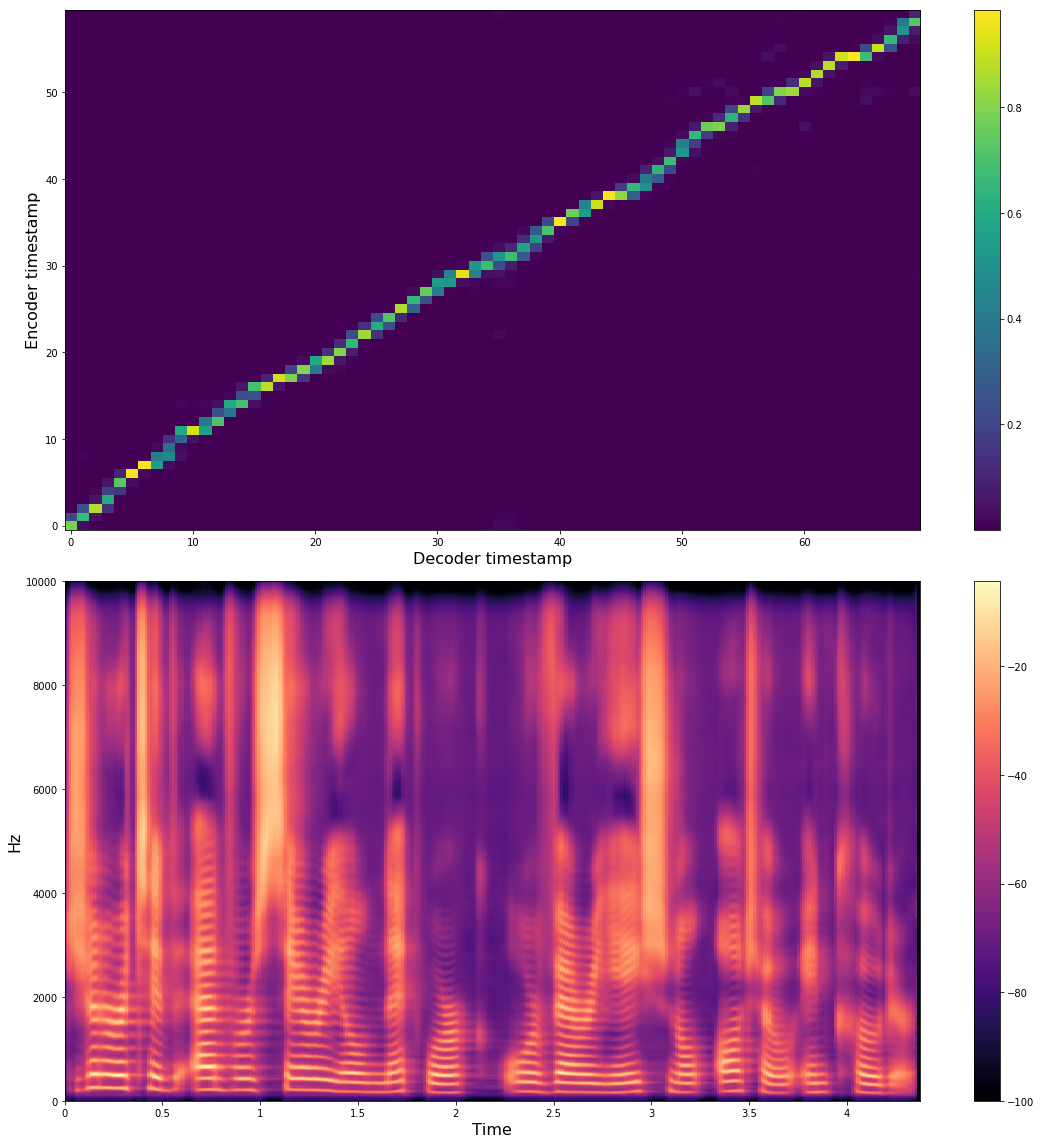

In [12]:
sentence = "Generative adversarial network or variational auto-encoder."
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

 >  Run-time: 14.10420560836792


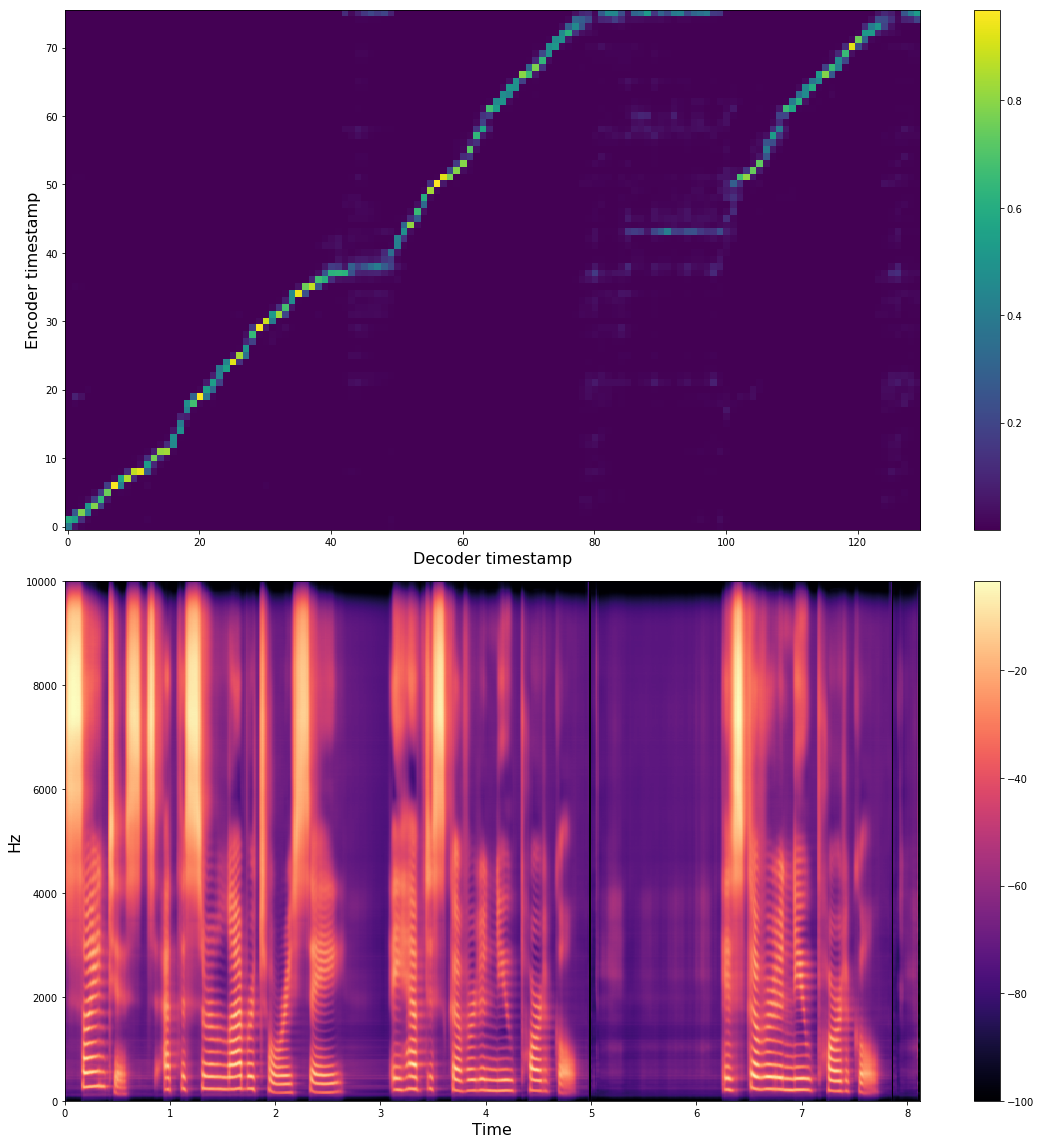

In [13]:
sentence = "Scientists at the CERN laboratory say they have discovered a new particle."
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

 >  Run-time: 12.206540584564209


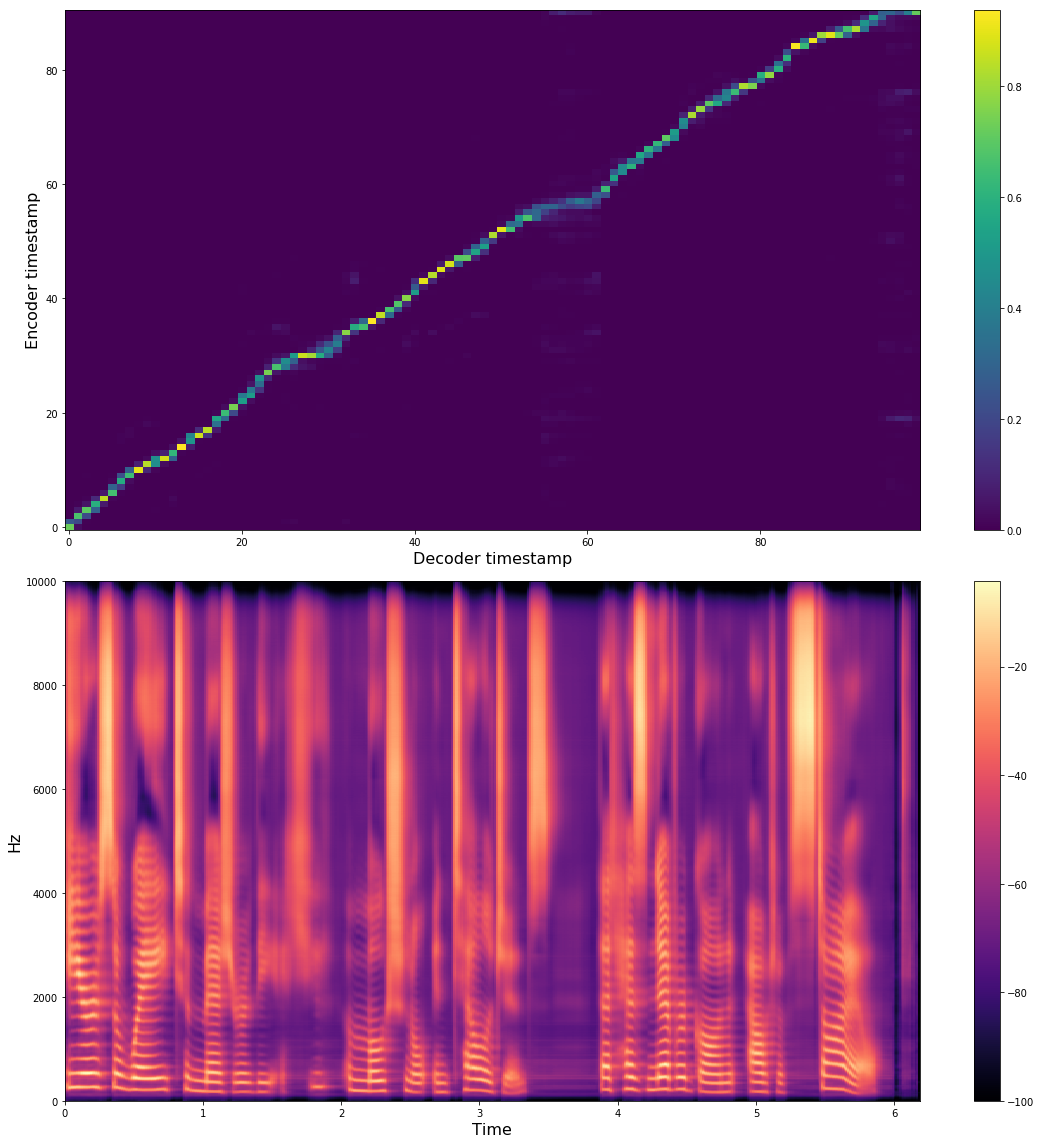

In [14]:
sentence = "here’s a way to measure the acute emotional intelligence that has never gone out of style."
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

 >  Run-time: 9.559785842895508


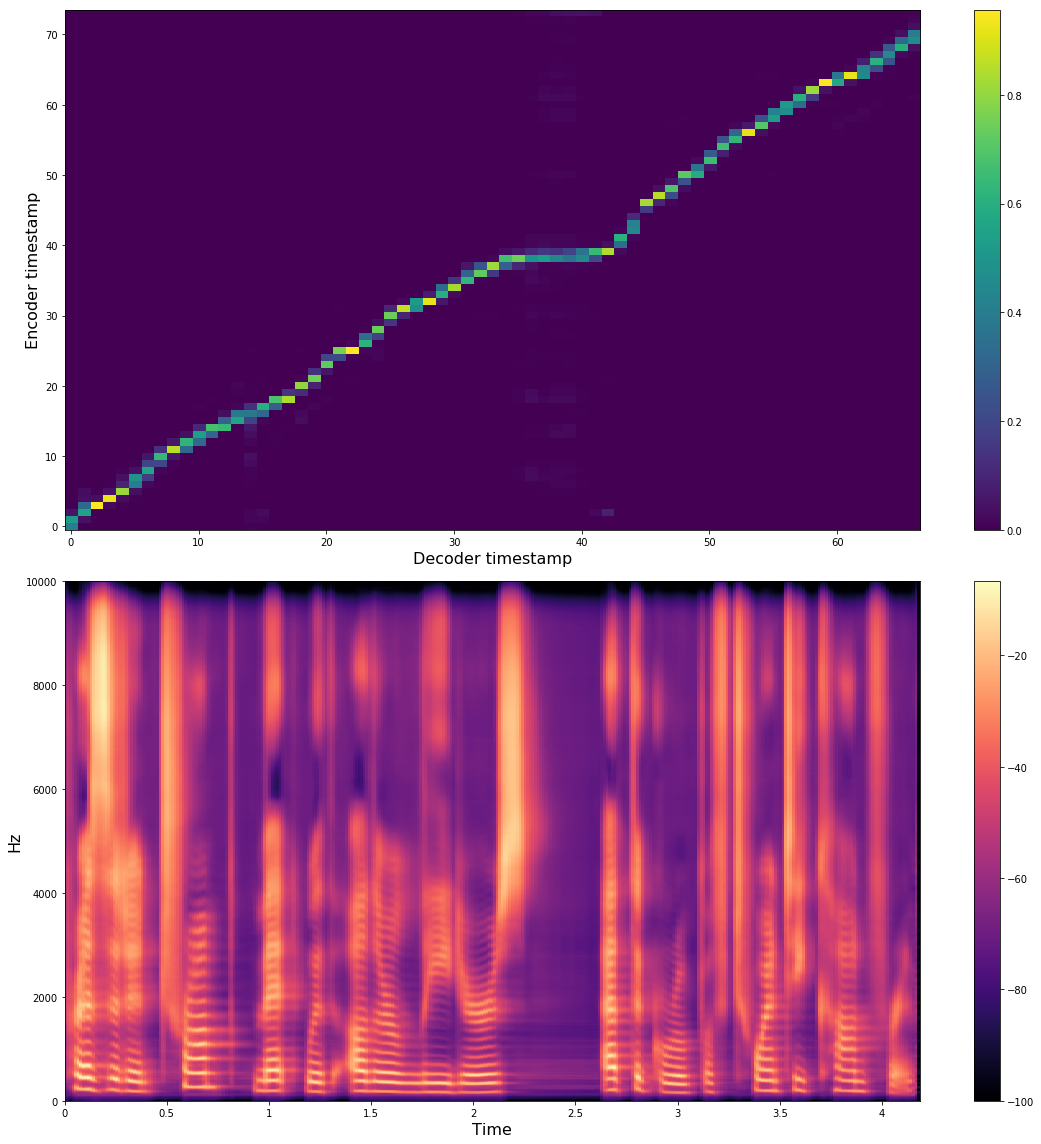

In [29]:
sentence = "President Trump met with other leaders at the Group of 20 conference."
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

 >  Run-time: 8.320220232009888


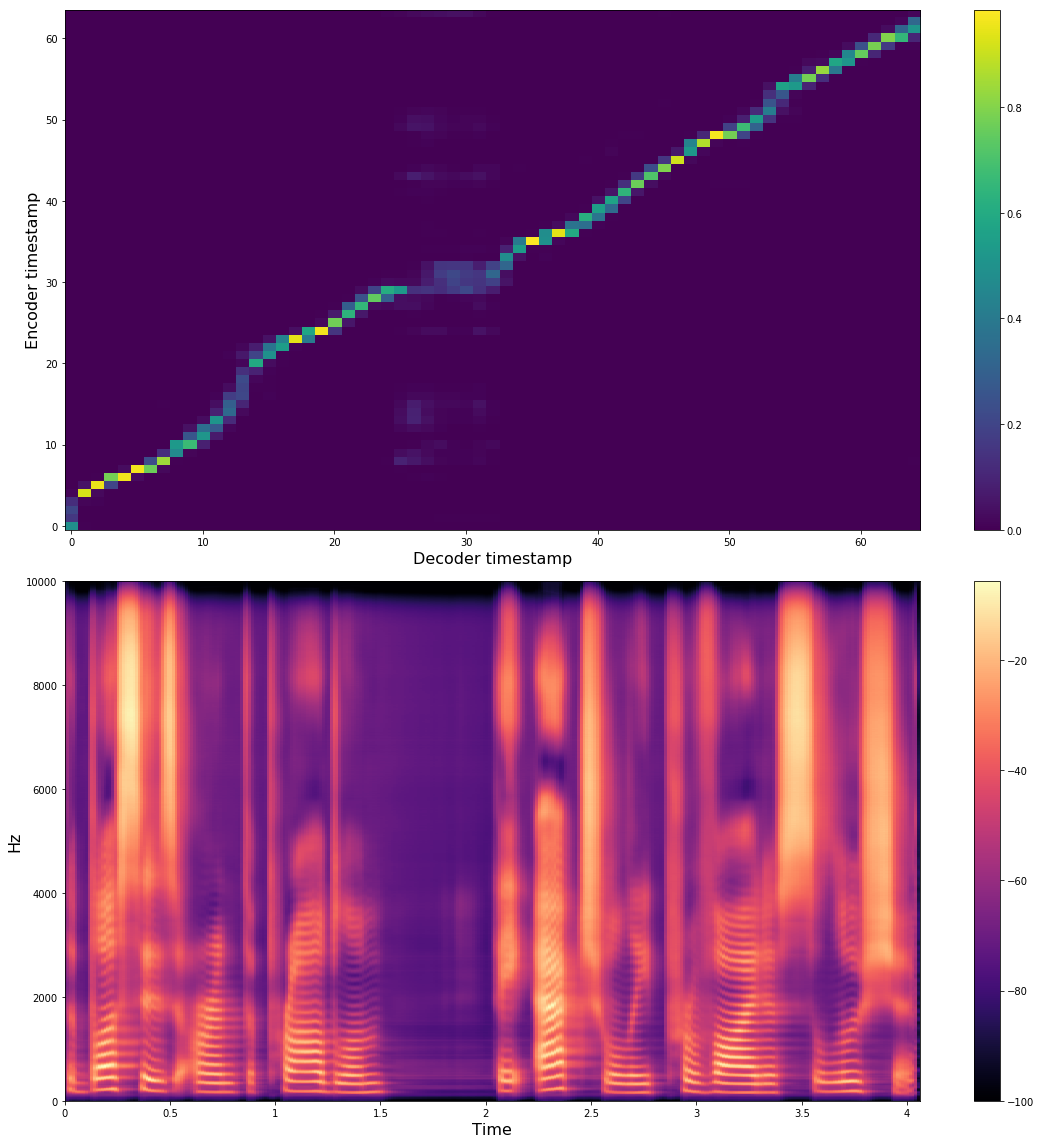

In [16]:
sentence = "The buses aren't the problem, they actually provide a solution."
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

In [31]:
len("President Trump met with other leaders at the Group of 20 conference.")

69

In [32]:
alignment[0].shape

(67, 74)

In [37]:
for i in range(alignment[0].shape[0]):
    a = alignment[0][i].max()
    print(a)

0.5278257
0.5526603
0.9558787
0.92132413
0.81367326
0.4858333
0.5570528
0.63596785
0.8613073
0.62610185
0.5429014
0.67617726
0.6459313
0.55958015
0.3836815
0.6041045
0.6867788
0.8378071
0.79800814
0.7517049
0.72250843
0.7627181
0.95597124
0.61695683
0.7325122
0.74086845
0.8736562
0.5194566
0.920689
0.5987127
0.82588756
0.63186014
0.7214943
0.8175821
0.66797817
0.7466511
0.48579764
0.5320349
0.43590546
0.36981428
0.45671675
0.6435481
0.84083676
0.61167735
0.44248602
0.8262451
0.8528732
0.6941957
0.7164757
0.58785707
0.6581132
0.66425616
0.62861
0.9175123
0.7020908
0.53642195
0.51358885
0.60365206
0.8154945
0.94948417
0.57743055
0.92082053
0.44779623
0.6089538
0.44988328
0.60405654
0.46145117


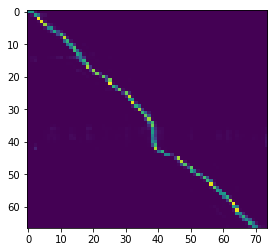

In [33]:
plt.imshow(alignment[0])